### TODO

- ~~Create the AdaIN layer~~
- ~~Create the reverse VGG19 model to have the decoder, and make it trainable~~
- ~~Create a custom model~~
- ~~Create the loss function~~
- ~~Automatically log the model and its hyperparameters on each training using MLFlow
--> Create a complete training pipeline : compile the model, fit it, log it (Add experiment and tags argument in the training function for the logging)~~
- ~~Create content and style datasets from the loaded images, with automatic image resizing pipeline for the training part (and eventually 256*256 window cropping)~~
- ~~Add getters and setters when required in AdaINDataModule (for train_val_test_split especially, maybe consider using the setattr method to handle all attributes at once)~~
- ~~Add verbose steps for the training process~~
- ~~Create the AdaINTrainer~~
- ~~Log the test loss in MLflow after training~~
- ~~Handle restart from checkpoint in AdaINTrainer~~
- ~~Add a function for image prediction that adds the imagenet means to the output and turns it back to RGB (and clips the values to [0,255])~~

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import mlflow
from mlflow.models import infer_signature
from mlflow.tracking import MlflowClient
from sklearn.model_selection import train_test_split
from torchvision import transforms

os.environ["KERAS_BACKEND"] = "torch"
import keras
from keras import Loss
from keras.preprocessing import image, image_dataset_from_directory # type: ignore
from pathlib import Path

from adain_model import AdaINModel, instance_mean, instance_std, AdaINLoss, ReflectiveConv2D
from adain_datamodule import AdaINDataModule
from adain_trainer import AdaINTrainer

In [11]:
dm = AdaINDataModule(Path("D:/StyleTransferAI/StyleTransferAI_AdaIN/datasets/unlabeled2017/"), Path("D:/StyleTransferAI/StyleTransferAI_AdaIN/datasets/WikiArt/"), dataset_size=100000, seed=444, batch_size=8)
model = AdaINModel(style_loss_weight=1, tv_loss_weight=1)

trainer = AdaINTrainer(model, dm, 'adam', mlflow_dir=Path("D:/Python/ML Flow/mlruns"), mlflow_tags={"Debugging" : True})
trainer.train(epochs=1, steps_per_epoch=10, log_every_n_epochs=1, validation_steps=1, test_steps=1)

Initiating datasets...
Compiling the model...
Model is ready to be trained
Training the model...


10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 669ms/step - loss: 285749664.0000 - val_loss: 811966.8750
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - loss: 946219.8125
The training is complete ! The model and its performances have been logged in MLFlow (Run ID : 06bdfd3e2dd846f5a091424d08d45ff8)


In [ ]:
trainer.train(epochs=1, steps_per_epoch=500, log_every_n_epochs=1, validation_steps=1, test_steps=1)

Training the model...


500/500 ━━━━━━━━━━━━━━━━━━━━ 208s 417ms/step - loss: 358756.9062 - val_loss: 341482.6875
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - loss: 336725.3125
The training is complete ! The model and its performances have been logged in MLFlow (Run ID : 3e985a81c9cf4f89a48b166ceb2d043c)


In [2]:
dm = AdaINDataModule(Path("D:/StyleTransferAI/StyleTransferAI_AdaIN/datasets/unlabeled2017/"), Path("D:/StyleTransferAI/StyleTransferAI_AdaIN/datasets/WikiArt/"), dataset_size=100000, seed=444, batch_size=8)
dm.create_datasets()
trained_model = AdaINModel.load_from_mlflow('2712841473f14dd0a572f733487ffeeb', Path('D:/Python/ML Flow/mlruns'))

In [ ]:
import torch.nn.functional as F
import skimage

def apply_filter(img, filter, decomposition_needed = True, hsv = True, show_img = True) :
    img = img.cpu().numpy()
    if decomposition_needed :
        if not hsv :
            red, green, blue = img[:,:,0], img[:,:,1], img[:,:,2]
            filter_r = filter(red)
            filter_g = filter(green)
            filter_b = filter(blue)
            filtered = np.permute_dims(np.stack((filter_r, filter_g, filter_b)), (1,2,0))
        else :
            hsv_img = skimage.color.rgb2hsv(img / 255.0).astype(np.float32)
            hue, saturation, value = hsv_img[:,:,0], hsv_img[:,:,1], hsv_img[:,:,2]
            filter_h = filter(hue)
            filter_s = filter(saturation)
            filter_v = filter(value)
            filtered = (skimage.color.hsv2rgb(np.permute_dims(np.stack((filter_h, filter_s, filter_v)), (1,2,0))) * 255).astype(int)
    else :
        filtered = filter(img / 255.0) * 255.0
    
    if show_img :
        plt.imshow(filtered)
        plt.axis('off')
        plt.show()
    else :
        return filtered
    

class AltModel(keras.Model) :
    def __init__(self, basis_model, decoder) :
        super().__init__()
        self.encoder = basis_model.encoder
        self.ada_in = basis_model.ada_in
        self.decoder = decoder

        self.device = basis_model.device
    
    def call(self, inputs, training = False, filter = None) :
        content = inputs[0]
        content = keras.applications.vgg19.preprocess_input(content).to(self.device) # Make sure the format of input is compatible with VGG (BGR, mean-centered)
        style = inputs[1]
        style = keras.applications.vgg19.preprocess_input(style).to(self.device)
        resized_style = keras.layers.Resizing(content.shape[1], content.shape[2])(style)

        encoded_content = self.encoder(content) 
        style_full_features = self.encoder(resized_style, all_features=True)
        encoded_style = style_full_features[-1]

        combined_features = self.ada_in(encoded_content, encoded_style)
        if filter is not None :
            for i in range(combined_features.shape[-1]) :
                for j in range(combined_features.shape[0]) :
                    channel = combined_features[j,:,:,i]
                    combined_features[j,:,:,i] = torch.tensor(apply_filter(channel, filter, decomposition_needed=False, hsv=False, show_img=False))

        decoded_img = self.decoder(combined_features)
        gen_image_full_features = self.encoder(decoded_img, all_features=True)

        # self.add_loss(self.loss_.total_loss(gen_image_full_features, style_full_features, combined_features, decoded_img))
        
        return decoded_img
    
    def generate(self, content_img : Path | str | torch.types.Tensor, style_img : Path | str | torch.types.Tensor, show_img = False, show_inputs = False, filter=None) :
        if isinstance(content_img, (Path, str)) :
            content_img = torch.tensor(keras.utils.img_to_array(keras.utils.load_img(content_img)))
        if isinstance(style_img, (Path, str)) :
            style_img = torch.tensor(keras.utils.img_to_array(keras.utils.load_img(style_img)))
        
        if content_img.max() <= 1.0 :
            content_img *= 255
        if style_img.max() <= 1.0 :
            style_img *= 255
        
        content_img = content_img.type(torch.int)
        style_img = style_img.type(torch.int)

        content_img.to(self.device)
        style_img.to(self.device)

        IMAGENET_MEANS = torch.tensor([103.939, 116.779, 123.68])
        gen_img = self.call([content_img.unsqueeze(0), style_img.unsqueeze(0)], training=False, filter=filter)[0]
        gen_img += IMAGENET_MEANS.to(self.device) # The decoder generates images normalized around the ImageNet means for each channel
        gen_img = gen_img.clone().cpu().type(torch.int)
        gen_img = gen_img.flip(dims=[-1]) # Convert BGR to RGB
        gen_img.clip_(0,255) 

        if show_img :
            if show_inputs :
                fig, axs = plt.subplots(1,3, figsize=(21,7))
                axs[0].imshow(content_img)
                axs[0].axis('off')
                axs[1].imshow(style_img)
                axs[1].axis('off')
                axs[2].imshow(gen_img)
                axs[2].axis('off')
            else :
                plt.imshow(gen_img)
                plt.axis('off')
                plt.show()
        else :
            return gen_img

class HybridUpSampling2D(keras.layers.Layer):
    def __init__(self, scale_factor=2, alpha=0.5, **kwargs):
        """
        Une couche d'UpSampling personnalisée qui combine "nearest" et "bilinear".
        
        size : facteur d'agrandissement (ex: (2,2) double la taille).
        alpha : poids du blending (0 = uniquement bilinear, 1 = uniquement nearest).
        """
        super(HybridUpSampling2D, self).__init__(**kwargs)
        self.scale_factor = scale_factor
        self.alpha = alpha

    def call(self, inputs):
        inputs = inputs.permute(0,3,1,2)
        # UpSampling avec méthode 'nearest'
        nearest = F.interpolate(inputs, scale_factor=self.scale_factor, mode='nearest')

        # UpSampling avec méthode 'bilinear' (align_corners=False pour éviter des artefacts)
        bilinear = F.interpolate(inputs, scale_factor=self.scale_factor, mode='bilinear', align_corners=False)

        out = self.alpha * nearest + (1 - self.alpha) * bilinear
        # Combinaison pondérée des deux
        return out.permute(0,2,3,1)

In [ ]:
import cv2 as cv

wolf = Path('D:/StyleTransferAI/StyleTransferAI/test_images/wolf_forest.jpg')
van_gogh = Path('D:/StyleTransferAI/StyleTransferAI/test_images/van_gogh.jpg')

alpha = 0

input = keras.Input((None,None,512))
x = input
for layer in trained_model.decoder.decoder.layers :
    if isinstance(layer, keras.layers.UpSampling2D) :
        x = HybridUpSampling2D(scale_factor=2, alpha=alpha)(x)
    else :
        x = layer(x)

new_decoder = keras.Model(input, x)
new_decoder.set_weights(trained_model.decoder.get_weights())

am = AltModel(trained_model, new_decoder)
# gen = am.generate(wolf, van_gogh)
# am.generate(wolf, van_gogh, show_img=True)

def median_filter(neighborhood = 1) :
    def fn(img) :
        return skimage.filters.median(img, skimage.morphology.disk(radius=neighborhood))
    return fn

def bilateral_filter(neighborhood = 5) :
    def fn(img) :
        return cv.bilateralFilter(img, d = neighborhood, sigmaColor = 20, sigmaSpace = 20)
    return fn

def nlm(h, patch_size = 7, patch_distance = 11, sigma = 0.0, fast_mode = True) :
    def fn(img) :
        return skimage.restoration.denoise_nl_means(img, h=h, patch_size=patch_size, patch_distance=patch_distance, sigma=sigma, fast_mode=fast_mode) #, channel_axis=2)
    return fn

def zero() :
    def fn(img) :
        return np.random.random(img.shape) * 10
    return fn

# apply_filter(gen, median_filter(neighborhood=2.5))
am.generate(wolf, van_gogh, show_img=True, filter=zero()) 

NameError: name 'HybridUpSampling2D' is not defined

In [ ]:
# IMAGENET_MEANS = torch.tensor([103.939, 116.779, 123.68]).to('cuda') #BGR means of ImageNet Dataset
imgs = []
torch.random.manual_seed(444)
for i, ((content, style), _) in enumerate(dm._train_dataset) :
    if i == 3 :
        break
    gen_img = model.generate(content, style)
    imgs.append([content.type(torch.int), style.type(torch.int), gen_img])

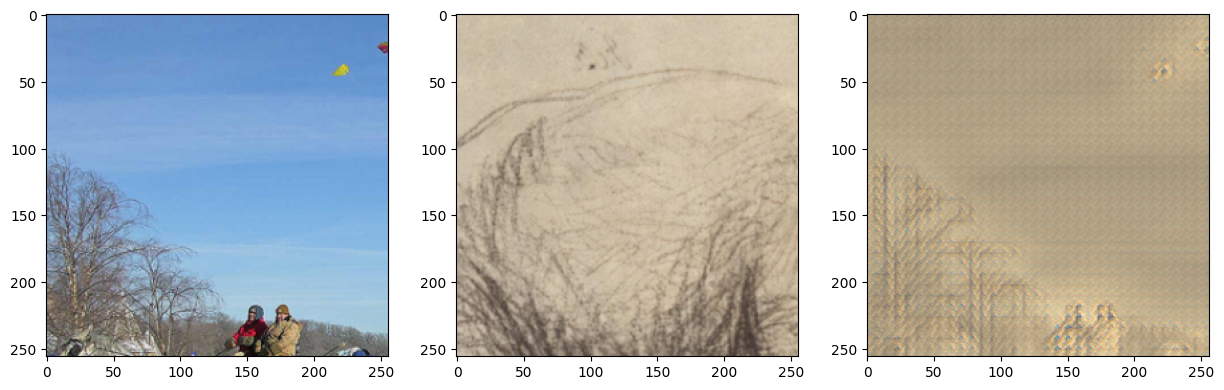

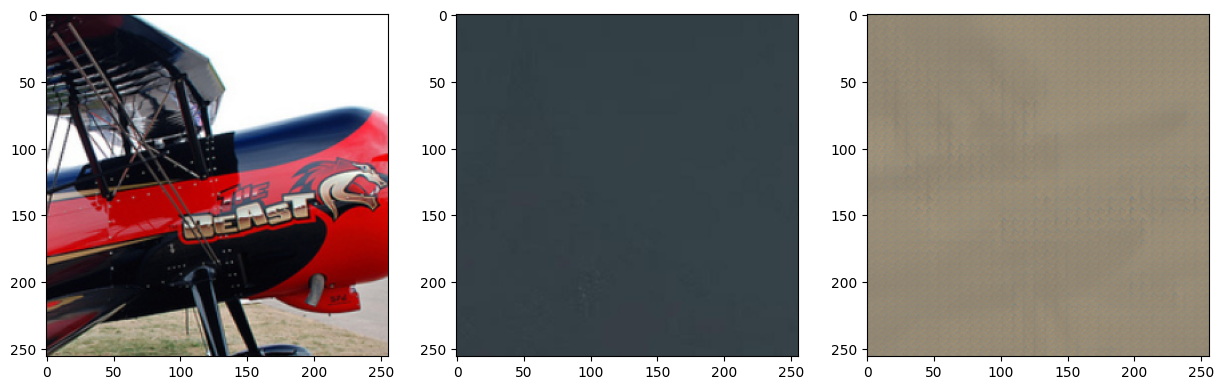

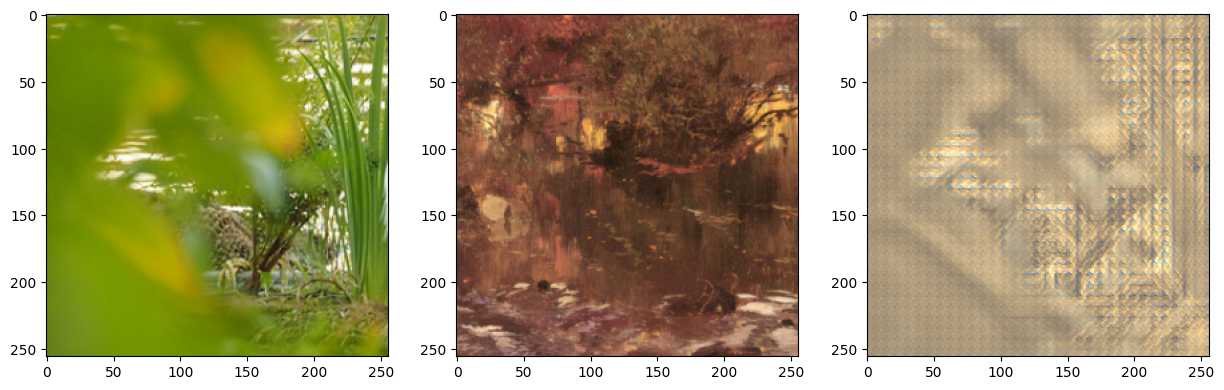

In [ ]:
for gen in imgs :
    fig, axs = plt.subplots(1,3, figsize=(15,5))
    for i in range(3) :
        axs[i].imshow(gen[i])
    plt.show()

In [3]:
wolf = Path('D:/StyleTransferAI/StyleTransferAI/test_images/wolf_forest.jpg')
van_gogh = Path('D:/StyleTransferAI/StyleTransferAI/test_images/van_gogh.jpg')
nature = Path('D:/StyleTransferAI/StyleTransferAI/test_images/nature.jpg')
wp = Path('D:/StyleTransferAI/StyleTransferAI/test_images/wallpaper.jpg')
wolf_big = Path('D:/StyleTransferAI/StyleTransferAI/test_images/wolf_forest_big.jpg')
drawing = Path('D:/StyleTransferAI/StyleTransferAI/test_images/croquis.jpg')
lion = Path('D:/StyleTransferAI/StyleTransferAI/test_images/lion.jpg')
fishes = Path('D:/StyleTransferAI/StyleTransferAI/test_images/peinture.webp')

In [ ]:
device = "cuda"
keras.src.backend.common.global_state.set_global_attribute("torch_device", device)
trained_model.to(device)
trained_model.device = device

In [4]:
size = 1500

wolf_img = torch.tensor(keras.utils.img_to_array(keras.utils.load_img(wolf))).unsqueeze(0)
sec_size = int((wolf_img.shape[2] / wolf_img.shape[1]) * size)
wolf_scaled = torch.nn.functional.interpolate(wolf_img.permute((0,3,1,2)), (size,sec_size), mode='bilinear').type(torch.int).permute((0,2,3,1))[0]

lion_img = torch.tensor(keras.utils.img_to_array(keras.utils.load_img(lion))).unsqueeze(0)
sec_size = int((lion_img.shape[2] / lion_img.shape[1]) * size)
lion_scaled = torch.nn.functional.interpolate(lion_img.permute((0,3,1,2)), (size,sec_size), mode='bilinear').type(torch.int).permute((0,2,3,1))[0]

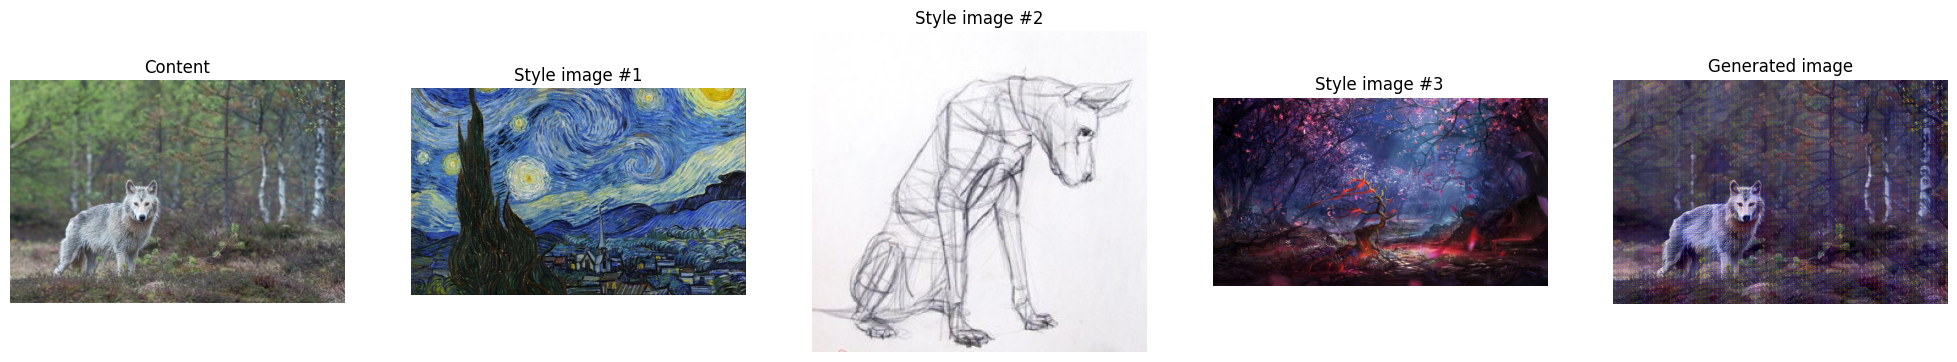

In [5]:
trained_model.generate(wolf, [van_gogh, drawing, wp], style_weights=[0.3,0,0.7], show_img=True, show_inputs=True)

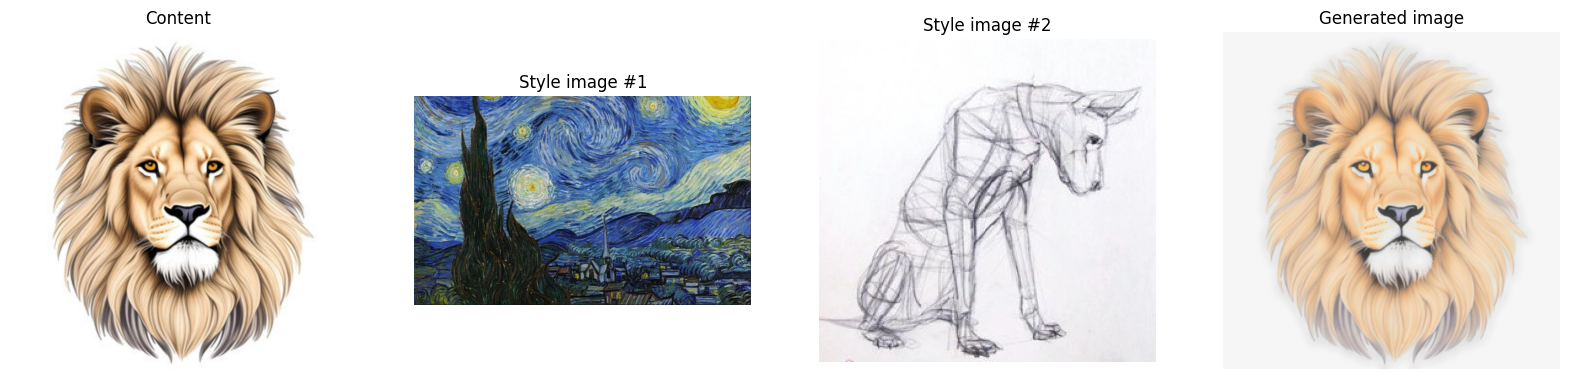

In [16]:
trained_model.generate(lion_scaled, [van_gogh, drawing], style_weights=[0.1,0.9], alpha=1, preserve_colors=True, show_img=True, show_inputs=True)

In [8]:
lab

array([[[255, 128, 128],
        [255, 128, 128],
        [255, 128, 128],
        ...,
        [255, 128, 128],
        [255, 128, 128],
        [255, 128, 128]],

       [[255, 128, 128],
        [255, 128, 128],
        [255, 128, 128],
        ...,
        [255, 128, 128],
        [255, 128, 128],
        [255, 128, 128]],

       [[255, 128, 128],
        [255, 128, 128],
        [255, 128, 128],
        ...,
        [255, 128, 128],
        [255, 128, 128],
        [255, 128, 128]],

       ...,

       [[255, 128, 128],
        [255, 128, 128],
        [255, 128, 128],
        ...,
        [255, 128, 128],
        [255, 128, 128],
        [255, 128, 128]],

       [[255, 128, 128],
        [255, 128, 128],
        [255, 128, 128],
        ...,
        [255, 128, 128],
        [255, 128, 128],
        [255, 128, 128]],

       [[255, 128, 128],
        [255, 128, 128],
        [255, 128, 128],
        ...,
        [255, 128, 128],
        [255, 128, 128],
        [255, 128, 128]]

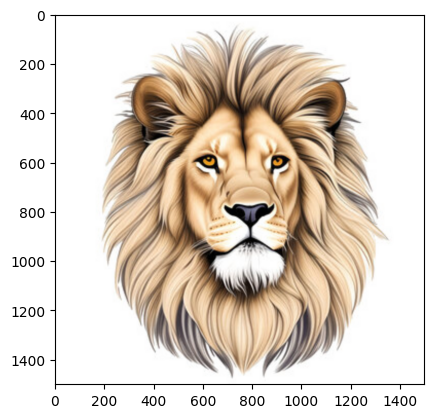

In [7]:
import cv2 as cv
lab = cv.cvtColor(lion_scaled.clone().cpu().numpy().astype(np.uint8), cv.COLOR_RGB2Lab)

plt.imshow(cv.cvtColor(lab, cv.COLOR_Lab2RGB))

In [ ]:
%timeit trained_model.generate(scaled, wp)

1.38 s ± 82.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-209..349].


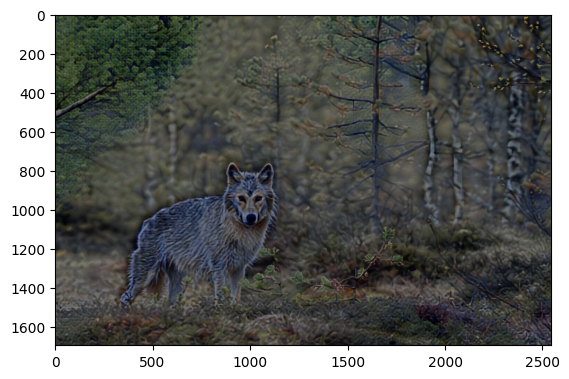

In [ ]:
content = torch.tensor(keras.utils.img_to_array(keras.utils.load_img(wolf_big)))
style = torch.tensor(keras.utils.img_to_array(keras.utils.load_img(van_gogh)))
IMAGENET_MEANS = torch.tensor([103.939, 116.779, 123.68]).to('cuda') #BGR means of ImageNet Dataset
gen_img = (trained_model([content.unsqueeze(0), style.unsqueeze(0)], training=False) + IMAGENET_MEANS).clone().detach().cpu().type(torch.int).flip(dims=[-1])[0]
plt.imshow(gen_img)

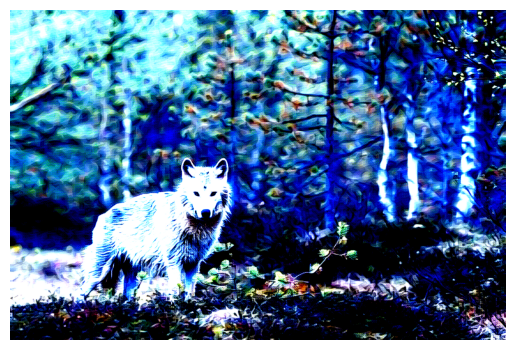

In [ ]:
trained_model.generate(scaled, van_gogh, show_img=True, alpha=5)

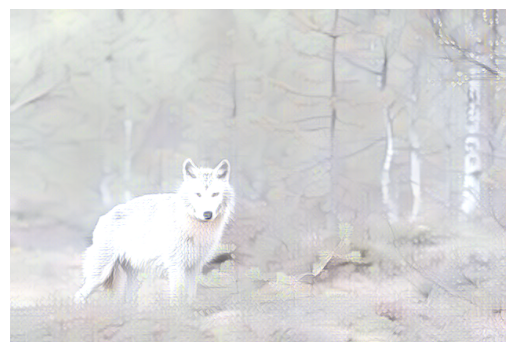

In [ ]:
trained_model.generate(wolf, drawing, alpha=1, show_img=True)

In [ ]:
torch.count_nonzero(gen_img < 0) / gen_img.numel()

tensor(0.0229)

In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()

2375